Vehicle velocity model with slope: closed loop model with P-only controller; iterative simulation approach.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Imports and helpers

In [3]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy import constants

In [4]:
def eval_model(model, xs):
    return np.array(list(map(model, xs)))

## Mathematical model

Model of a closed loop system with proportional controller

$\frac{dv(t)}{dt} = \frac{1}{m} [ F_p K_c (v_{SP}(t) - v(t)) - \frac{1}{2} \rho A C_d v(t)^2 ] - g sin(\theta)$

In [5]:
# Mass (car + load), kg
m = 700

# Thrust parameter, (N / %pedal)
F_p = 30

# Air density, kg/m^3
rho = 1.225 

# vehicle cross-sectional area (m^2)
A = 5

# Drag coefficient
C_d = 0.24

# Controller gain
K_c = 13.037
#K_c = 20.

def vehicle_model(v, t, setpoint_func, disturbance_func):
    
    v_sp = setpoint_func(t)
    theta = disturbance_func(t)
        
    drive = F_p * K_c * (v_sp - v)
    drag = 0.5 * rho * A * C_d * (v**2)
    slope = constants.g * np.sin(theta)
    
    return (1. / m) * (drive - drag) - slope
    

## Simulation

In [6]:
t = np.linspace(0, 200, 100)

In [7]:
# setpoint function
def setpoint_strategy(t):
    
    if t < 25:
        return 0
    
    if t >= 25 and t < 100:
        return 10
    
    if t >= 100 and t < 150:
        return 15
    
    if t >= 150:
        return 10
    
# disturbance function   
def no_slope(t):
    return 0

Iterative simulation

In [8]:
initial = 0
v_sim = [initial, ]

for i in range(len(t) - 1):
    
    # take t[i] and t[i+1]
    t_pair = t[i:i+2]
    t_now, t_next = t_pair
    
    step_sim = odeint(vehicle_model, initial, t_pair, args=(setpoint_strategy, no_slope))

    # take the last value
    v_last = step_sim.reshape(-1)[-1]

    # appendt it to the resulting list
    v_sim.append(v_last)
    
    # save it as initial condition for the next run
    initial = v_last 
    
v_sim = np.array(v_sim).reshape(-1)

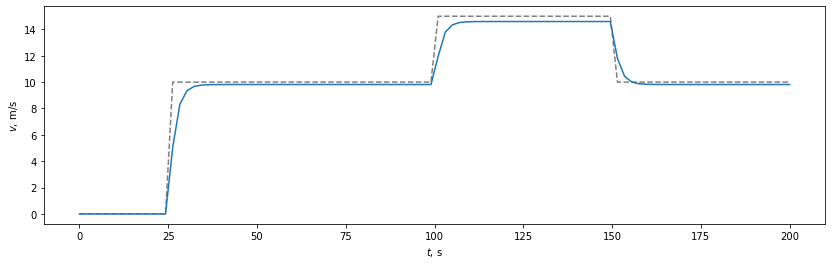

In [9]:
plt.figure(figsize=(14, 4))
plt.plot(t, eval_model(setpoint_strategy, t), '--', color='gray')
plt.plot(t, v_sim)

plt.xlabel('$t$, s')
plt.ylabel('$v$, m/s')
plt.show()

In [10]:
v_sim

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  5.0501087 ,  8.33049008,
        9.35621643,  9.67521834,  9.77426142,  9.80499619,  9.81453207,
        9.81749059,  9.81840843,  9.81869318,  9.81878152,  9.81880893,
        9.81881749,  9.81882012,  9.81882092,  9.81882117,  9.81882126,
        9.81882129,  9.81882131,  9.81882129,  9.81882131,  9.8188213 ,
        9.81882131,  9.8188213 ,  9.81882131,  9.8188213 ,  9.81882131,
        9.8188213 ,  9.81882131,  9.8188213 ,  9.81882131,  9.8188213 ,
        9.81882131,  9.8188213 ,  9.81882131,  9.8188213 ,  9.81882131,
       11.9534209 , 13.79236935, 14.35383743, 14.52475462, 14.57673643,
       14.59254171, 14.59734679, 14.59880768, 14.59925182, 14.59938686,
       14.59942791, 14.59944048, 14.59944426, 14.59944541, 14.59944576,
       14.59944587, 14.5994459 , 14.59944592, 14.5994459 , 14.59

In [11]:
error = eval_model(setpoint_strategy, t) - v_sim

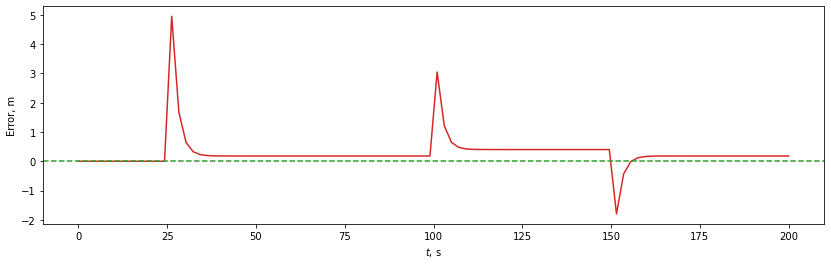

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(t, error, color='tab:red')
plt.axhline(0, linestyle='--', color='tab:green')
plt.xlabel('$t$, s')
plt.ylabel('Error, m')
plt.show()

In [13]:
sse = np.sum(np.square(error))

print('Sum of squared errors during simulation: {:.3f}'.format(sse))

Sum of squared errors during simulation: 47.804
